# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import matplotlib.pyplot as plt
import random
import numpy as np
import scipy.misc
import cv2
from scipy import ndimage
from skimage import util
from skimage import exposure
from skimage.transform import rotate
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Visualizations will be shown in the notebook.
%matplotlib inline


# TODO: Fill this in based on where you saved the training and testing data

training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = len(X_train[0])

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)



Number of training examples = 39209
Number of testing examples = 12630
Image data shape = 32
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

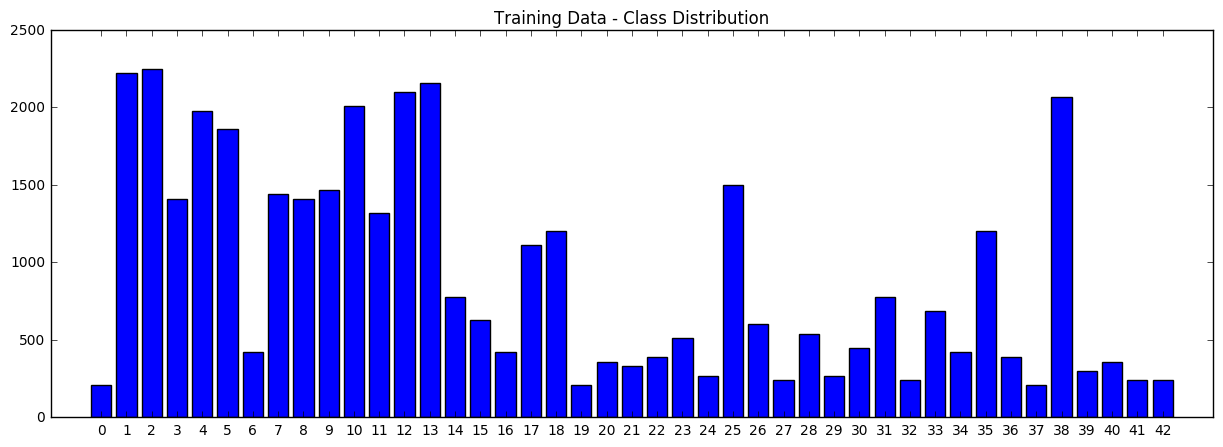

In [4]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
label_train, n = np.unique(y_train, return_counts=True)

axes = plt.gca()
axes.set_xlim([-2,44])
plt.rcParams["figure.figsize"] = [15, 5]
plt.bar(label_train, n, tick_label=label_train, width=0.8, align='center')
plt.title('Training Data - Class Distribution')

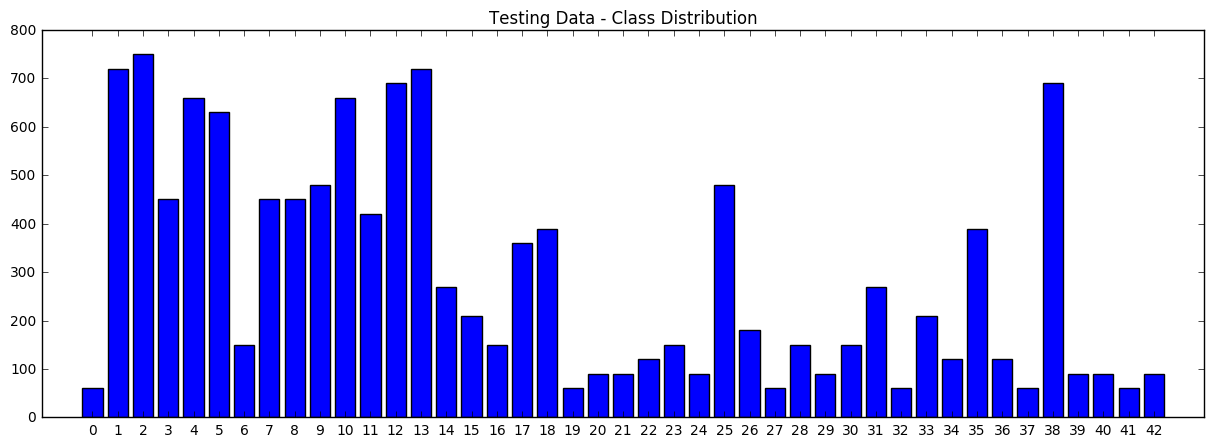

In [5]:
label_test, m = np.unique(y_test, return_counts=True)

axes = plt.gca()
axes.set_xlim([-2,44])
plt.rcParams["figure.figsize"] = [10, 5]
plt.bar(label_test, m, tick_label=label_test, width=0.8, align='center')
plt.title('Testing Data - Class Distribution')

Train Dataset Visualization


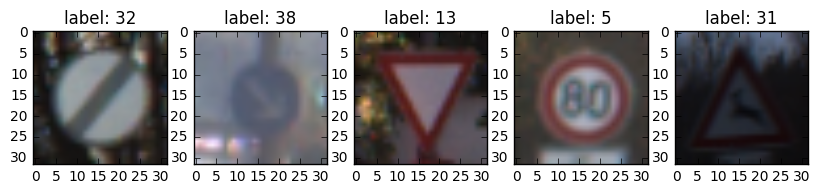

In [6]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
print("Train Dataset Visualization")
for i in range(0,5):
    index = random.randint(0, len(X_train))
    image = X_train[index].squeeze() 
    plt.subplot(1,5,i+1)
    plt.imshow(image, cmap="gray")
    plt.title('label: %d' % y_train[index])

Test Dastaset Visualization


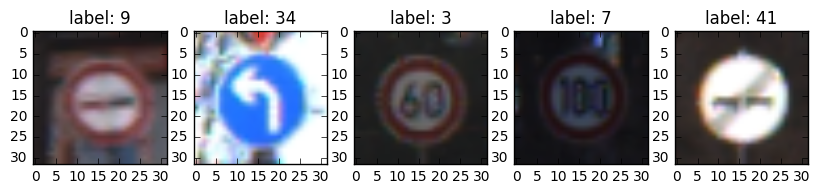

In [7]:
print("Test Dastaset Visualization")
for i in range(0,5):
    index = random.randint(0, len(X_test))
    image_test = X_test[index].squeeze() 
    plt.subplot(1,5,i+1)
    plt.imshow(image_test, cmap="gray")
    plt.title('label: %d' % y_test[index])

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

Normalized Dataset Visualization


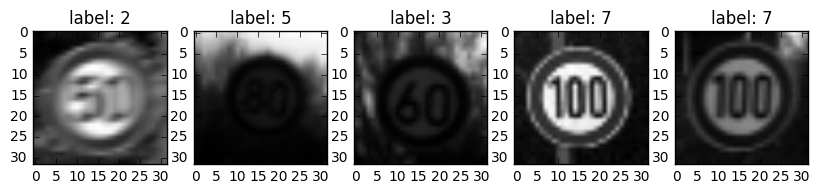

In [8]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
def grayscale(images):
    gray = np.average(images, axis=3)
    gray = np.expand_dims(gray, axis=3)
    return gray

def normalize(image_data):    
    image_data = image_data.astype('float32')
    image_data = (image_data - 128.0)/128.0
    return image_data

X_train = normalize(grayscale(X_train))
X_test = normalize(grayscale(X_test))

print("Normalized Dataset Visualization")
for i in range(0,5):
    index = random.randint(0, len(X_test))
    image_norm = X_train[index].squeeze() 
    plt.subplot(1,5,i+1)
    plt.imshow(image_norm, cmap="gray")
    plt.title('label: %d' % y_train[index])

In [9]:
X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)
#X_train = np.concatenate((X_train,X_test),axis=0)
#y_train = np.concatenate((y_train,y_test),axis=0)
print(X_train.shape)
print(y_train.shape)
n_train = len(X_train)

(39209, 32, 32, 1)
(39209,)


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**
The techniques used to preprocessed the data are given below:

* RGB to grayscale, with the aim to reduce the amount of parameters and only few colors are used for traffic signs.
    * grayscale = (R + G + B)/3
* Normalization between -1 to 1, zero centered data for fast convergence as mentioned on the lectures.
    * normalization = (image_data - 128)/128
* One hot encoding to implement multiclass classificaton (performed on architecture definition stage)


In [10]:
### Generate additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
print("Loading dataset again...")
with open(training_file, mode='rb') as f:
    augmented = pickle.load(f)
    
X_augmented, y_augmented = augmented['features'], augmented['labels']
print(X_augmented.shape)

Loading dataset again...
(39209, 32, 32, 3)


Augmented Dataset - Rotation 15 degree
(15000, 32, 32, 1)
(15000,)


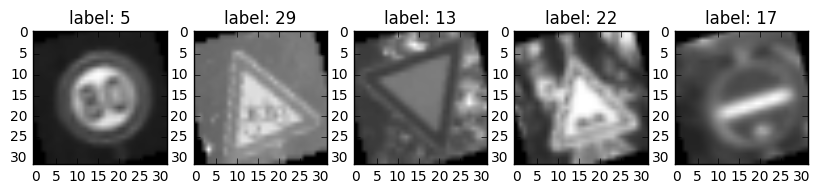

In [11]:
X_augmented, y_augmented = shuffle(X_augmented, y_augmented)
X_rot1 = grayscale(X_augmented[0:15000])
y_rot1 = y_augmented[0:15000]
for i in range(0,15000):
    X_rot1[i] = rotate(X_rot1[i], 15, resize=False)
X_rot1 = normalize(X_rot1)
print("Augmented Dataset - Rotation 15 degree")
print(X_rot1.shape)
print(y_rot1.shape)
for i in range(0,5):
    index = random.randint(0, len(X_rot1))
    image_rot1 = X_rot1[index].squeeze() 
    plt.subplot(1,5,i+1)
    plt.imshow(image_rot1, cmap="gray")
    plt.title('label: %d' % y_rot1[index])

Augmented Dataset - Rotation -15 degree
(15000, 32, 32, 1)
(15000,)


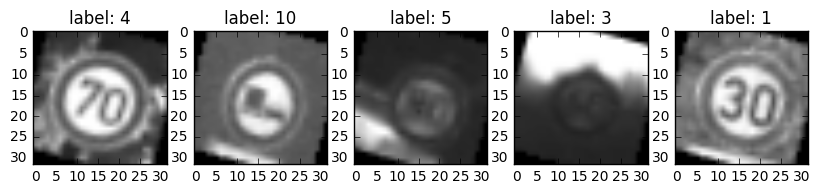

In [12]:
X_augmented, y_augmented = shuffle(X_augmented, y_augmented)
X_rot2 = grayscale(X_augmented[0:15000])
y_rot2 = y_augmented[0:15000]
for i in range(0,15000):
    X_rot2[i] = rotate(X_rot2[i], -15, resize=False)
X_rot2 = normalize(X_rot2)
print("Augmented Dataset - Rotation -15 degree")
print(X_rot2.shape)
print(y_rot2.shape)
for i in range(0,5):
    index = random.randint(0, len(X_rot2))
    image_rot2 = X_rot2[index].squeeze() 
    plt.subplot(1,5,i+1)
    plt.imshow(image_rot2, cmap="gray")
    plt.title('label: %d' % y_rot2[index])

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "


Augmented Dataset - Histogram Equalization
(15000, 32, 32, 1)
(15000,)


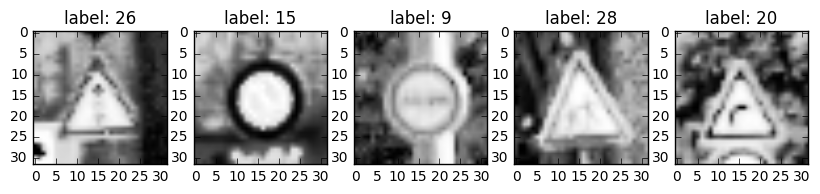

In [13]:
X_augmented, y_augmented = shuffle(X_augmented, y_augmented)
X_equ = grayscale(X_augmented[0:15000])
y_equ = y_augmented[0:15000]
for i in range(0,15000):
    X_equ[i] = exposure.equalize_hist(X_equ[i])
X_equ = normalize(X_equ)
print("Augmented Dataset - Histogram Equalization")
print(X_equ.shape)
print(y_equ.shape)
for i in range(0,5):
    index = random.randint(0, len(X_equ))
    image_equ = X_equ[index].squeeze() 
    plt.subplot(1,5,i+1)
    plt.imshow(image_equ, cmap="gray")
    plt.title('label: %d' % y_equ[index])

In [14]:
X_augmented, y_augmented = shuffle(X_augmented, y_augmented)
X_augmented = util.random_noise(X_augmented[0:(55000-n_train)], mode='poisson', seed=None, clip=True)
y_augmented = y_augmented[0:(55000-n_train)]
print("Augmented Dataset - Poisson Noise")
print(X_augmented.shape)
print(y_augmented.shape)

Augmented Dataset - Poisson Noise
(15791, 32, 32, 3)
(15791,)


Augmented Noisy Dataset Visualization


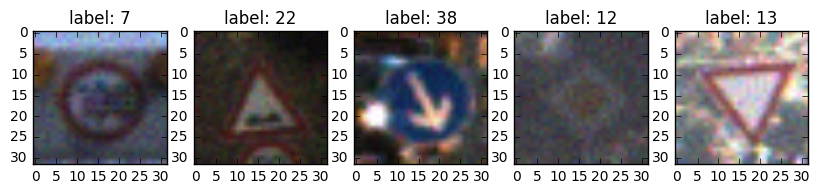

In [15]:
print("Augmented Noisy Dataset Visualization")
for i in range(0,5):
    index = random.randint(0, len(X_augmented))
    image_aug = X_augmented[index].squeeze() 
    plt.subplot(1,5,i+1)
    plt.imshow(image_aug, cmap="gray")
    plt.title('label: %d' % y_augmented[index])

In [16]:
X_augmented = grayscale(X_augmented) 
print("Augmented Dataset - Poisson Noise - Grayscale")
print(X_augmented.shape)

Augmented Dataset - Poisson Noise - Grayscale
(15791, 32, 32, 1)


In [17]:
X_augmented = X_augmented*2.0-1.0  
print("Augmented Dataset - Poisson Noise - Zero Mean")
print(X_augmented.shape)

Augmented Dataset - Poisson Noise - Zero Mean
(15791, 32, 32, 1)


In [18]:
X_train = np.concatenate((X_train,X_augmented,X_rot1,X_rot2,X_equ),axis=0)
y_train = np.concatenate((y_train,y_augmented,y_rot1,y_rot2,y_equ),axis=0)
print("Train Dataset and Augmented Dataset Concatenation")
print(X_train.shape)
print(y_train.shape)
n_augmented =len(X_train)

Train Dataset and Augmented Dataset Concatenation
(100000, 32, 32, 1)
(100000,)


In [19]:
###Shuffling the new dataset
%reset_selective -f X_augmented
%reset_selective -f y_augmented
%reset_selective -f X_rot1
%reset_selective -f y_rot1
%reset_selective -f X_rot2
%reset_selective -f y_rot2
%reset_selective -f X_salt
%reset_selective -f y_salt
X_train, y_train = shuffle(X_train, y_train)

In [20]:
### and split the data into training/validation/testing sets here.
### Feel free to usas many code cells as needed.
print("Training, validation and testing datasets definition (80 10 10)")
#X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.20)
#X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size = 0.50)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size = 0.10)

print(X_train.shape)
print(y_train.shape)
print(X_validation.shape)
print(y_validation.shape)
print(X_test.shape)
print(y_test.shape)

Training, validation and testing datasets definition (80 10 10)
(90000, 32, 32, 1)
(90000,)
(10000, 32, 32, 1)
(10000,)
(12630, 32, 32, 1)
(12630,)


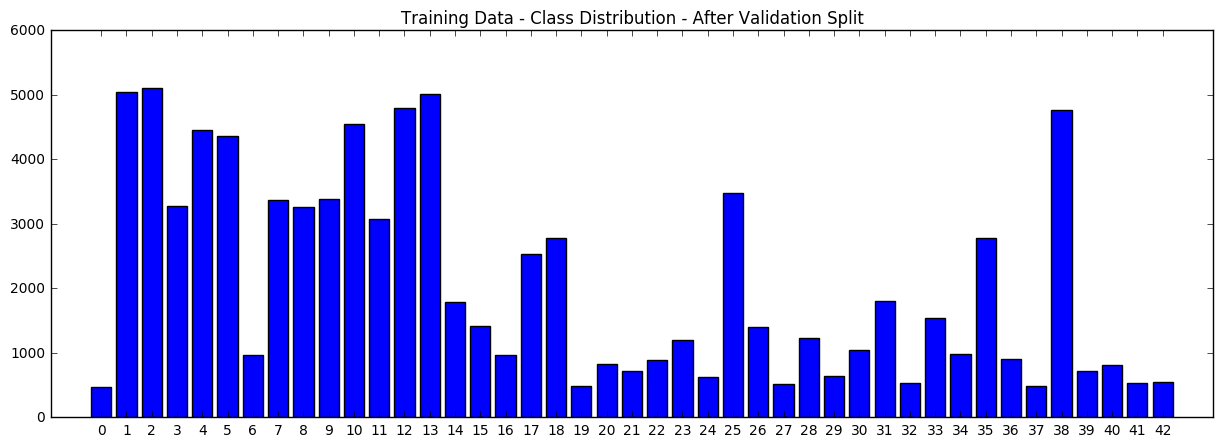

In [22]:
label_train, n = np.unique(y_train, return_counts=True)

axes = plt.gca()
axes.set_xlim([-2,44])
plt.rcParams["figure.figsize"] = [15, 5]
plt.bar(label_train, n, tick_label=label_train, width=0.8, align='center')
plt.title('Training Data - Class Distribution - After Validation Split')

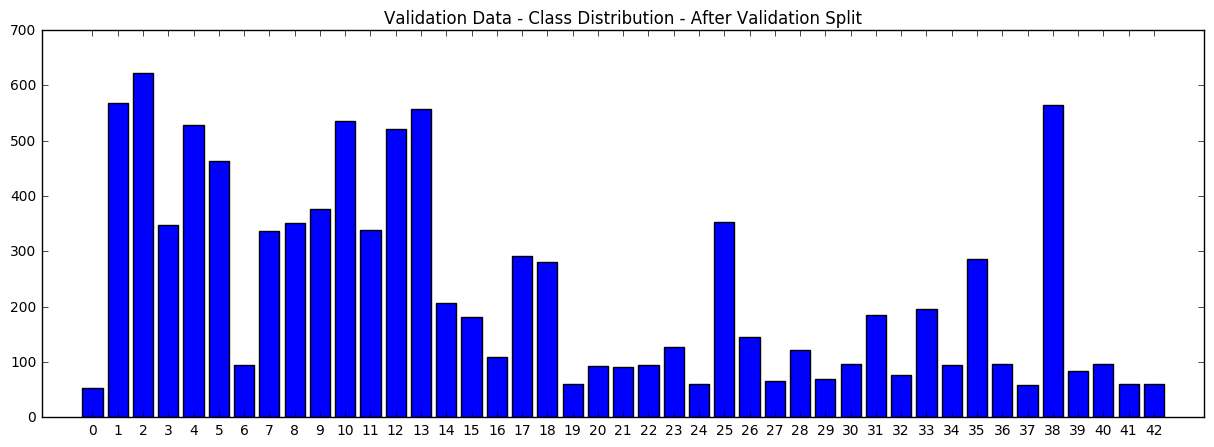

In [23]:
label_validation, n = np.unique(y_validation, return_counts=True)

axes = plt.gca()
axes.set_xlim([-2,44])
plt.rcParams["figure.figsize"] = [15, 5]
plt.bar(label_validation, n, tick_label=label_validation, width=0.8, align='center')
plt.title('Validation Data - Class Distribution - After Validation Split')

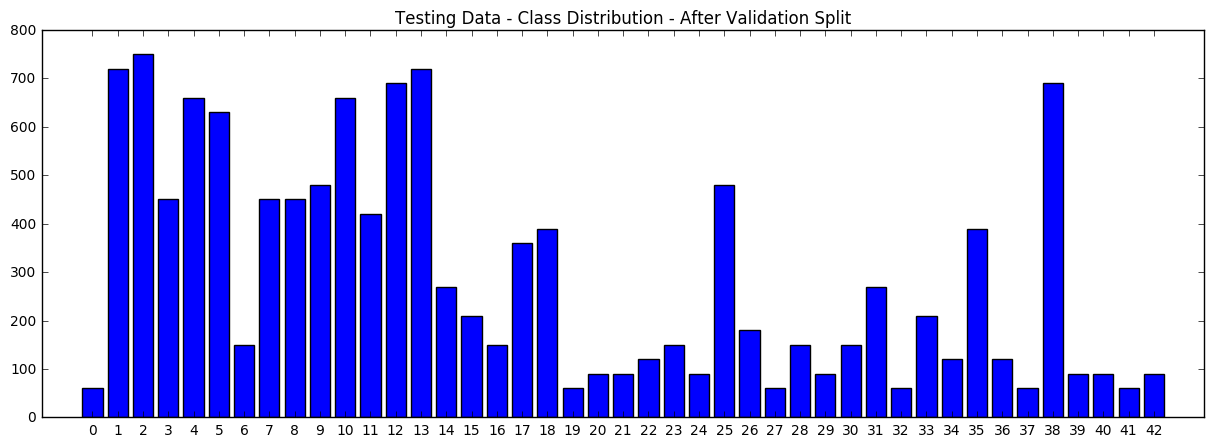

In [24]:
label_test, n = np.unique(y_test, return_counts=True)

axes = plt.gca()
axes.set_xlim([-2,44])
plt.rcParams["figure.figsize"] = [15, 5]
plt.bar(label_test, n, tick_label=label_test, width=0.8, align='center')
plt.title('Testing Data - Class Distribution - After Validation Split')

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**
Details about cross validation and additional data are shown below:

* For aditional data (jittered data), i chose to add noise using Poisson Distribution, apply Histogram Equalization, also a 15 and -15 degrees rotation to small datasets in order to increase final dataset to 100000. Traslation and scaling could be achieve better results; however, i choose to implement a simple model with a small dataset and architecture.
* To split the whole dataset, i merge the whole dataset (Train and Augmented datasets to achieve 100000 samples). Then, i chose the 80-10-10 data split (train, validation, testing). Also, i ensure to shuffle the data before performing the data split to randomize which instances fall into each dataset and ensuring that the distribution of the classes in each dataset are similar.


In [33]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
import tensorflow as tf

EPOCHS = 35
BATCH_SIZE = 75

from tensorflow.contrib.layers import flatten

def DeepNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    #weights dimensions [height,width,input_depth,output_depth]
    #strides dimensions [batch_size,height,width,depth]
    
    # TODO: Layer 0: Convolutional. Input = 32x32x1. Output = 32x32x8.
    conv_layer0_w = tf.Variable(tf.truncated_normal([3,3,1,8]))
    conv_layer0_b = tf.Variable(tf.zeros(8))
    conv_layer0 = tf.nn.conv2d(x,conv_layer0_w,strides=[1,1,1,1],padding='SAME') + conv_layer0_b
    conv_layer0 = tf.nn.relu(conv_layer0)
    
    # TODO: Layer 1: Convolutional. Input = 32x32x8. Output = 30x30x12. 
    conv_layer1_w = tf.Variable(tf.truncated_normal([3,3,8,12]))
    conv_layer1_b = tf.Variable(tf.zeros(12))
    conv_layer1 = tf.nn.conv2d(conv_layer0,conv_layer1_w,strides=[1,1,1,1],padding='VALID') + conv_layer1_b
    
    # TODO: Activation.
    conv_layer1 = tf.nn.relu(conv_layer1)
    
    # TODO: Pooling. Input = 30x30x12. Output = 15x15x12.
    conv_layer1 = tf.nn.max_pool(conv_layer1,ksize=[1,1,1,1],strides=[1,2,2,1],padding='VALID')
    
    # TODO: Layer 2: Convolutional. Output = 13x13x24.
    # now input_depth is 12 and output depth is 24
    conv_layer2_w = tf.Variable(tf.truncated_normal([3,3,12,24]))
    conv_layer2_b = tf.Variable(tf.zeros(24))
    conv_layer2 = tf.nn.conv2d(conv_layer1,conv_layer2_w,strides=[1,1,1,1],padding='VALID') + conv_layer2_b
    
    # TODO: Activation.
    conv_layer2 = tf.nn.relu(conv_layer2)
    
    # TODO: Pooling. Input = 9x9x24. Output = 6x6x24.
    conv_layer2 = tf.nn.max_pool(conv_layer2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
        
    # TODO: Flatten. Input = 4x4x32. Output = 864.
    flatten_layer2   = flatten(conv_layer2)
    
    # TODO: Layer 3: Fully Connected. Input = 512. Output = 480.
    fc_layer3_w = tf.Variable(tf.truncated_normal(shape=(864,480), mean = mu, stddev = sigma))
    fc_layer3_b = tf.Variable(tf.zeros(480))
    fc_layer3 = tf.matmul(flatten_layer2, fc_layer3_w) + fc_layer3_b

    # TODO: Activation.
    fc_layer3 = tf.nn.relu(fc_layer3)
    #fc_layer3 = tf.nn.dropout(fc_layer3,0.75)

    # TODO: Layer 4: Fully Connected. Input = 480. Output = 200.
    fc_layer4_w = tf.Variable(tf.truncated_normal(shape=(480,200), mean = mu, stddev = sigma))
    fc_layer4_b = tf.Variable(tf.zeros(200))
    fc_layer4 = tf.matmul(fc_layer3, fc_layer4_w) + fc_layer4_b
    
    # TODO: Activation.
    fc_layer4 = tf.nn.relu(fc_layer4)
    #fc_layer4 = tf.nn.dropout(fc_layer4,0.75)
    
    # TODO: Layer 6: Fully Connected. Input = 150. Output = 43.
    fc_layer5_w = tf.Variable(tf.truncated_normal(shape=(200,43), mean = mu, stddev = sigma))
    fc_layer5_b = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc_layer4, fc_layer5_w) + fc_layer5_b
    
    return logits

In [34]:
### Define your architecture here.
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

#rate = 0.5 #(Virtual Machine Linux)
rate = 0.05 #(AWS Linux)

logits = DeepNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdadeltaOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**
The architecture of the model is based on convolutional neural networks with similar structure as LeNet. The architecture have 3 convolutional layers and 3 fully connected layers. Due small dimensions of input images and small amount of classes, the overall dimensions of the layers are pretty small as detailed below.

* Convolutional layer with 3x3 kernel, Depth = 8, Stride = 1 and "SAME" padding.
* ReLU Activation.
* Convolutional layer with 3x3 kernel, Depth = 12, Stride = 1 and "VALID" padding.
* ReLU Activation.
* Max pooling with 1x1 kernel, Stride = 2 and "VALID" padding.
* Convolutional layer with 3x3 kernel, Depth = 24, Stride = 1 and "VALID" padding.
* ReLU Activation.
* Max pooling with 2x2 kernel, Stride = 2 and "VALID" padding.
* Fully-connected layer with 480 hidden units.
* ReLU Activation.
* Fully-connected layer with 200 hidden units.
* ReLU Activation.
* Fully-connected layer with 43 hidden units (logits).


In [35]:
### Train your model here.
### Feel free to use as many code cells as needed.
prediction = tf.argmax(logits, 1)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()
history = []

def acc_evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        values = sess.run(tf.nn.softmax(logits),feed_dict={x: batch_x})
        indexes = sess.run(prediction, feed_dict={x: batch_x, y: batch_y})
        predictions = sess.run(correct_prediction, feed_dict={x: batch_x, y: batch_y})
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return values, indexes, predictions, total_accuracy / num_examples

In [36]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = acc_evaluate(X_validation, y_validation)
        train_accuracy = acc_evaluate(X_train, y_train)
        history.append((train_accuracy,validation_accuracy))
        print("EPOCH {} ... Validation Accuracy = {:.3f}".format(i+1,validation_accuracy))
        
    saver.save(sess, 'deepnet.ckpt')
    print("Model saved")

Training...

EPOCH 1 ... Validation Accuracy = 0.694
EPOCH 2 ... Validation Accuracy = 0.778
EPOCH 3 ... Validation Accuracy = 0.820
EPOCH 4 ... Validation Accuracy = 0.830
EPOCH 5 ... Validation Accuracy = 0.809
EPOCH 6 ... Validation Accuracy = 0.835
EPOCH 7 ... Validation Accuracy = 0.865
EPOCH 8 ... Validation Accuracy = 0.841
EPOCH 9 ... Validation Accuracy = 0.829
EPOCH 10 ... Validation Accuracy = 0.895
EPOCH 11 ... Validation Accuracy = 0.874
EPOCH 12 ... Validation Accuracy = 0.902
EPOCH 13 ... Validation Accuracy = 0.902
EPOCH 14 ... Validation Accuracy = 0.863
EPOCH 15 ... Validation Accuracy = 0.818
EPOCH 16 ... Validation Accuracy = 0.899
EPOCH 17 ... Validation Accuracy = 0.924
EPOCH 18 ... Validation Accuracy = 0.932
EPOCH 19 ... Validation Accuracy = 0.924
EPOCH 20 ... Validation Accuracy = 0.930
EPOCH 21 ... Validation Accuracy = 0.911
EPOCH 22 ... Validation Accuracy = 0.894
EPOCH 23 ... Validation Accuracy = 0.929
EPOCH 24 ... Validation Accuracy = 0.918
EPOCH 25 ...

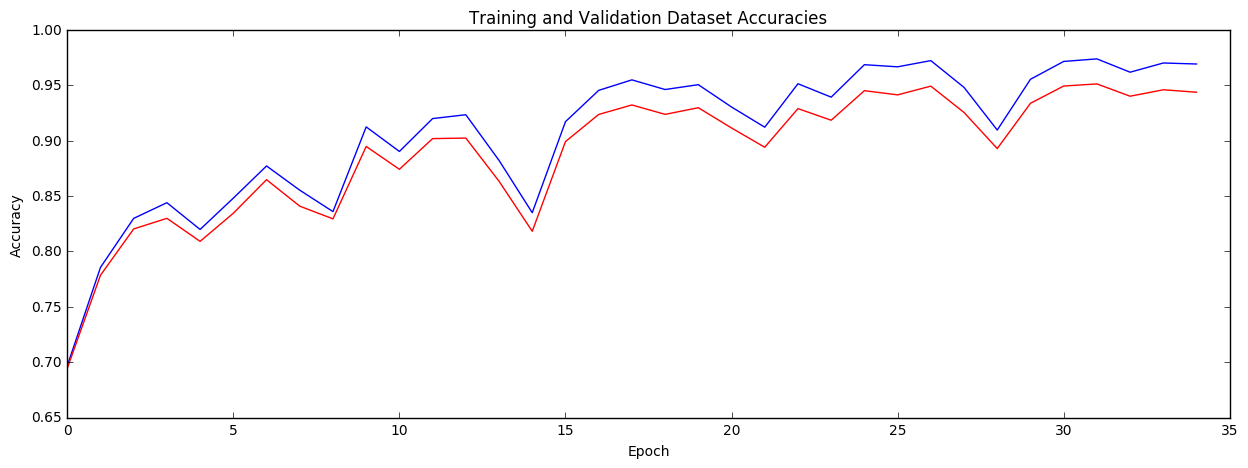

In [37]:
history = np.transpose(np.array(history))
plt.plot(history[0], 'b')  # training
plt.plot(history[1], 'r')  # validation
plt.title('Training and Validation Dataset Accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

In [38]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_values, test_indexes, test_predictions, test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.914


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
 I chose to use Adadelta as optimizer based on this lecture (http://sebastianruder.com/optimizing-gradient-descent/index.html#adadelta). The whole configuration is shown below:

* Optimizer: Adadelta
* Batch size: 75
* Epochs: 35
* Learning Rate: 0.5 (Virtual Machine Linus)
* Learning Rate: 0.05 (Native Linux, Curiously)
* mu: 0, as LeNet Lab (also i have zero centered data)
* sigma: 0.1, as LeNet Lab


### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**
The approach to solve the problem was chosen by reading about some good practices in neural network architecture for traffic sign classification (e.g. given paper about LeNet Architecture for traffic sign classification, Convolutional Neural Network lectures, etc.). In addition, since a small dataset, with small color images are given, a small architecture as LeNet is appropiate to achive good results on traffic sign classification problem. Moreover, Batch size, Learning rate and the number of EPOCHS were chosen following the recommendations given on TensorFlow Neural Network Lab. First, i fixed the number of EPOCHS to 1, Learning Rate to 0.1 in order to test the model with different batch sizes (2000, 1000, 500, 250, 100, 50); then, i fixed, the number of EPOCHS to 1, the batch size to 75, to test the model with different learning rates (0.8, 0.5, 0.2, 0.1, 0.01, 0.001); Finally, the learning rate and batch size were fixed with the aim to test the model with different amount of EPOCHS.


---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [39]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
from PIL import Image

filenames = ["1.png","2.png","3.png","4.png","5.png","6.png","7.png","8.png","9.png","10.png"]
images = []

for image_file in filenames:
    image = Image.open(image_file)
    image = image.convert('RGB')
    image = np.array(list(image.getdata()), dtype='uint8')
    image = np.reshape(image, (32, 32, 3))
    images.append(image)
images = np.array(images, dtype='uint8')
images = normalize(grayscale(images))
y_final_test = np.zeros((10,))
y_final_test[0] = 0
y_final_test[1] = 2
y_final_test[2] = 14
y_final_test[3] = 5
y_final_test[4] = 33
y_final_test[5] = 23
y_final_test[6] = 13
y_final_test[7] = 35
y_final_test[8] = 34
y_final_test[9] = 18

print("Final Test 1 - German Traffic Sign Images")
print(images.shape)
print(y_final_test.shape)

Final Test 1 - German Traffic Sign Images
(10, 32, 32, 1)
(10,)


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

On test 2, Five USA traffic signs was chosen to test the model. One of the traffic signs does not exist on the dataset used to train the model (i just to know what the model predicts), the two other signs are a bit different (shapes, colors, etc.) and the model fails to predict the correct label, however with similar signs the model predicts certainly. The accuracy of the test on these images was 40%.

On test 3, Five German traffic signs was chosen from Google Street to test the model. The accuracy of the test on these images was 100%.


Final Test 1 - German Traffic Sign Images - Accuracy = 0.900
Predictions:  [ True  True False  True  True  True  True  True  True  True]
Labels:       [ 0  2 17  5 33 23 13 35 34 18]
Keep Prob:    [ 1.          0.99999619  1.          1.          1.          1.          1.
  1.          1.          1.        ]


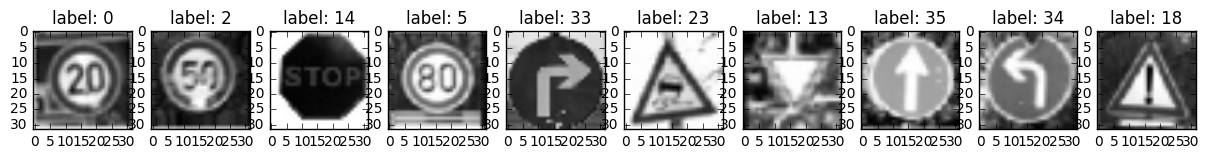

In [40]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    final_test_values, final_test_indexes, final_test_predictions, final_test_accuracy = evaluate(images, y_final_test)
    print("Final Test 1 - German Traffic Sign Images - Accuracy = {:.3f}".format(final_test_accuracy))

for i in range(0,10):
    image = images[i].squeeze() 
    plt.subplot(1,10,i+1)
    plt.imshow(image, cmap="gray")
    plt.title('label: %d' % y_final_test[i])
the_values= np.zeros((10))
for i in range(0,10):
    the_values[i] = final_test_values[i][final_test_indexes[i]]
print("Predictions: ",final_test_predictions)
print("Labels:      ",final_test_indexes)
print("Keep Prob:   ",the_values.T)

Final Test 2 - USA Traffic Sign Images
Test Accuracy = 0.400
Predictions:  [False False False  True  True]
Labels:       [40 12  1 14 13]
Keep Prob:    [ 0.99997151  1.          0.97428697  0.99996662  1.        ]


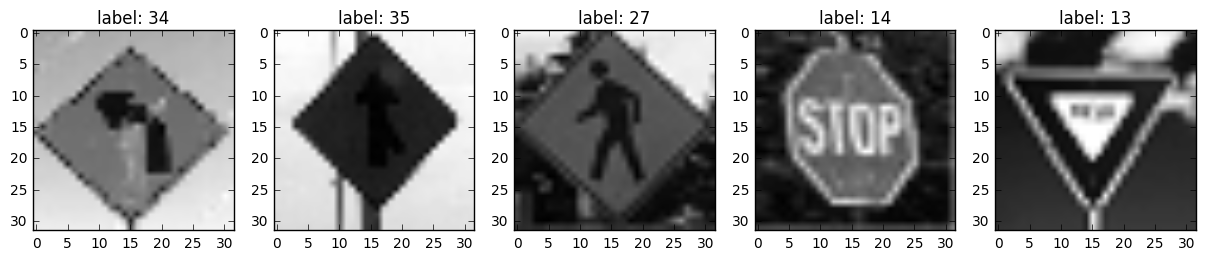

In [41]:
filenames2 = ["a.png","b.png","c.png","d.png","e.png"]
images2 = []

for image_file2 in filenames2:
    image2 = Image.open(image_file2)
    #image2 = image.convert('RGB')
    image2 = np.array(list(image2.getdata()), dtype='uint8')
    image2 = np.reshape(image2, (32, 32, 3))
    images2.append(image2)
images2 = np.array(images2, dtype='uint8')
images2 = normalize(grayscale(images2))
y_final_test2 = np.zeros((5,))
y_final_test2[0] = 34
y_final_test2[1] = 35
y_final_test2[2] = 27
y_final_test2[3] = 14
y_final_test2[4] = 13

print("Final Test 2 - USA Traffic Sign Images")

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    final_test2_values, final_test2_indexes, final_test2_predictions, final_test2_accuracy = evaluate(images2, y_final_test2)
    print("Test Accuracy = {:.3f}".format(final_test2_accuracy))

for i in range(0,5):
    image2 = images2[i].squeeze() 
    plt.subplot(1,5,i+1)
    plt.imshow(image2, cmap="gray")
    plt.title('label: %d' % y_final_test2[i])
the_values2= np.zeros((5))
for i in range(0,5):
    the_values2[i] = final_test2_values[i][final_test2_indexes[i]]
print("Predictions: ",final_test2_predictions)
print("Labels:      ",final_test2_indexes)
print("Keep Prob:   ",the_values2.T)

Final Test 3 - German Traffic Sign Images (Google Street)
(5, 32, 32, 1)
(5,)
Test Accuracy = 1.000
Predictions:  [ True  True  True  True  True]
Labels:       [25 34 36 12 35]
Keep Prob:    [ 1.          1.          0.99997389  1.          1.        ]


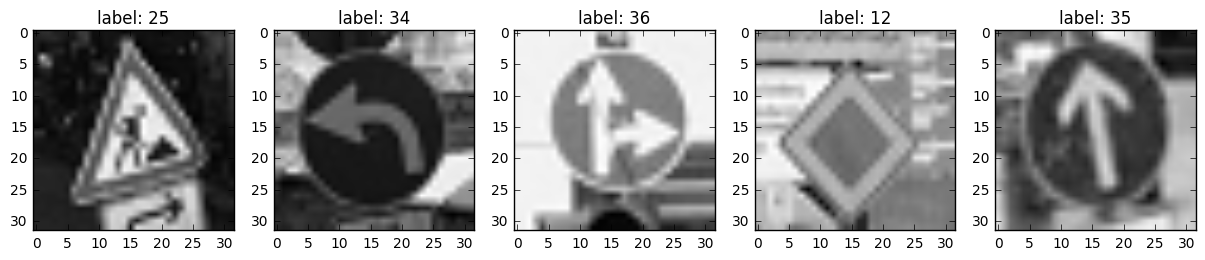

In [45]:
filenames3 = ["I.png","II.png","III.png","IV.png","V.png"]
images3 = []

for image_file3 in filenames3:
    image3 = Image.open(image_file3)
    image3 = image3.convert('RGB')
    image3 = np.array(list(image3.getdata()), dtype='uint8')
    image3 = np.reshape(image3, (32, 32, 3))
    images3.append(image3)
images3 = np.array(images3, dtype='uint8')
images3 = normalize(grayscale(images3))
y_final_test3 = np.zeros((5,))
y_final_test3[0] = 25
y_final_test3[1] = 34
y_final_test3[2] = 36
y_final_test3[3] = 12
y_final_test3[4] = 35

print("Final Test 3 - German Traffic Sign Images (Google Street)")
print(images3.shape)
print(y_final_test3.shape)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    final_test3_values, final_test3_indexes, final_test3_predictions, final_test3_accuracy = evaluate(images3, y_final_test3)
    print("Test Accuracy = {:.3f}".format(final_test3_accuracy))

for i in range(0,5):
    image3 = images3[i].squeeze() 
    plt.subplot(1,5,i+1)
    plt.imshow(image3, cmap="gray")
    plt.title('label: %d' % y_final_test3[i])
the_values3= np.zeros((5))
for i in range(0,5):
    the_values3[i] = final_test3_values[i][final_test3_indexes[i]]
print("Predictions: ",final_test3_predictions)
print("Labels:      ",final_test3_indexes)
print("Keep Prob:   ",the_values3.T)

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**
Since, i was not able to take pictures of local traffic signs in an easy way (i'm pretty sure that are very different). I decided to use 10 german traffic signs taken from the internet for the first test. The model predicts certainly the 9 images achieving 90% of accuracy. On the second test, i chose to use 5 USA traffic signs. The model achieve 40% of accuracy taking into account that some are a bit different, but some others are quite different. On the third test, i chose to use 5 German traffic signs from Google Street. The model achieve 100% of accuracy. I think with a fine tunning the model could achieve better accuracy.

Final Teset 1
* From the prediction I did to the ten images on the test, the testing accuracy is 90% (verifying test dataset results), however, the model prediction accuracy on the training set was 91% (Honestly, I would not trust a model that fails 9 out of 100 trials).
* As a result, I believe my model did perform almost well in the real world situation. The possible reason for uncertainty would be light conditions that difficult proper prediction for signs that contains numbers or letters (speed limit signs, also stop sign).

Final Teset 2
* From the prediction I did to the five images on the test (USA traffic sign), the testing accuracy is 40%, however, the model prediction accuracy on the training set was 92%.
* As a result, I believe my model did not perform well in the real world situation. The reason is that two signs are a bit different from the dataset (different shape and color) and one of them even does not exist on the dataset (i intentionally chose this sign). Also, the images are from a USA dataset.

Final Teset 3
* From the prediction I did to the five images on the test (German traffic sign - Google Street), the testing accuracy is 100%, however, the model prediction accuracy on the training set was 92%.
* As a result, I believe my model did perform well in the real world situation. The reason is that the images were taken in ideal conditions (day light, no shiny surfaces).

Softmax probabilities for Test 1 

[TopKV2(values=array([ 1.,  0.,  0.,  0.,  0.], dtype=float32), indices=array([0, 1, 2, 3, 4], dtype=int32)), TopKV2(values=array([  9.99996185e-01,   3.84267742e-06,   2.46416019e-16,
         1.56794377e-21,   7.81068032e-23], dtype=float32), indices=array([ 2, 14,  4,  5,  1], dtype=int32)), TopKV2(values=array([  1.00000000e+00,   3.44199278e-13,   2.27045572e-15,
         9.74191695e-26,   2.34062744e-28], dtype=float32), indices=array([17, 33, 14, 34, 39], dtype=int32)), TopKV2(values=array([  1.00000000e+00,   3.74855115e-22,   1.47025038e-31,
         0.00000000e+00,   0.00000000e+00], dtype=float32), indices=array([5, 1, 2, 0, 3], dtype=int32)), TopKV2(values=array([  1.00000000e+00,   9.88695072e-19,   3.35522450e-21,
         7.07644456e-23,   1.04196346e-23], dtype=float32), indices=array([33, 25, 19, 14, 21], dtype=int32)), TopKV2(values=array([ 1.,  0.,  0.,  0.,  0.], dtype=float32), indices=array([23,  0,  1,  2,  3], dtype=int32)), To

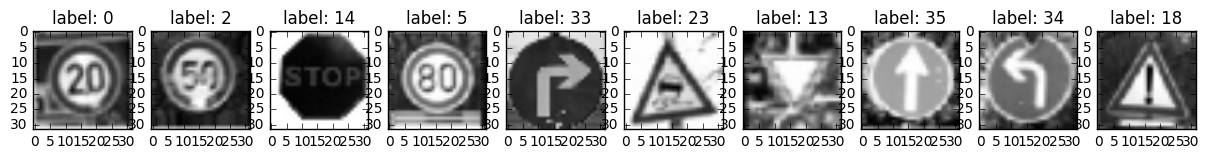

In [78]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
print("Softmax probabilities for Test 1 ")
print()
vals = []
for i in range(0,10):
    image = images[i].squeeze() 
    plt.subplot(1,10,i+1)
    plt.imshow(image, cmap="gray")
    plt.title('label: %d' % y_final_test[i])
with tf.Session() as sess:
    for i in range(0,10):
        val = sess.run(tf.nn.top_k(tf.constant(final_test_values[i]), k=5)) 
        vals.append(val)  
print(vals)

Softmax probabilities for Test 2 - USA Traffic Signs 

[TopKV2(values=array([  9.99971509e-01,   2.85114675e-05,   6.46825047e-18,
         1.68701496e-19,   1.86431321e-22], dtype=float32), indices=array([40, 12, 17,  7,  8], dtype=int32)), TopKV2(values=array([  1.00000000e+00,   1.00214508e-32,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00], dtype=float32), indices=array([12, 14,  0,  1,  2], dtype=int32)), TopKV2(values=array([  9.74286973e-01,   2.55902130e-02,   1.22150508e-04,
         6.04499121e-07,   1.39370659e-09], dtype=float32), indices=array([ 1,  6, 32,  4, 17], dtype=int32)), TopKV2(values=array([  9.99966621e-01,   1.72638611e-05,   1.60605359e-05,
         2.16501501e-08,   1.24972656e-14], dtype=float32), indices=array([14, 17, 40,  2, 37], dtype=int32)), TopKV2(values=array([ 1.,  0.,  0.,  0.,  0.], dtype=float32), indices=array([13,  0,  1,  2,  3], dtype=int32))]


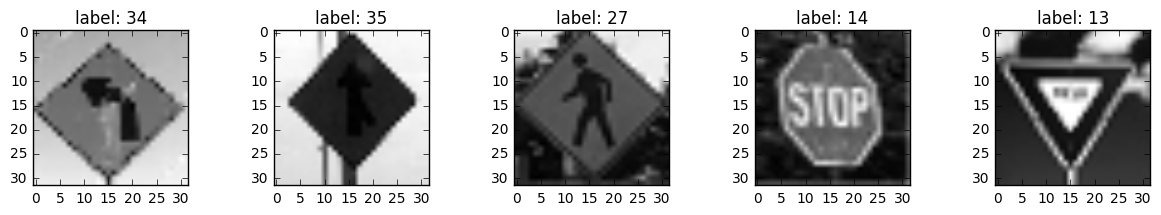

In [84]:
print("Softmax probabilities for Test 2 - USA Traffic Signs ")
print()
vals2 = []
for i in range(0,5):
    image2 = images2[i].squeeze() 
    plt.subplot(1,5,i+1)
    plt.imshow(image2, cmap="gray")
    plt.title('label: %d' % y_final_test2[i])
with tf.Session() as sess:
    for i in range(0,5):
        val2 = sess.run(tf.nn.top_k(tf.constant(final_test2_values[i]), k=5)) 
        vals2.append(val2)  
print(vals2)

Correct - Label 34: Turn Left
Predicted - Label 40: Roundabout mandatory


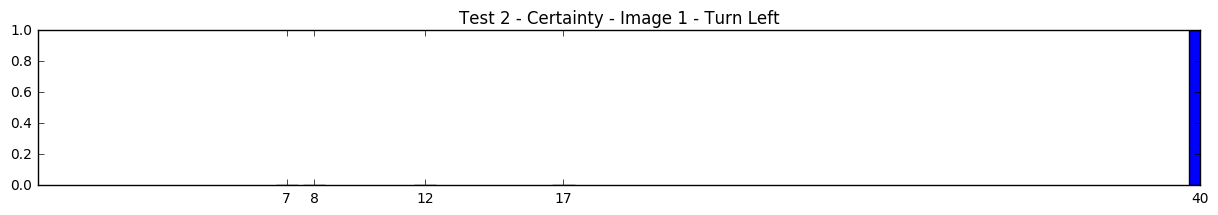

In [93]:
axes = plt.gca()
axes.set_xlim([-2,7])
plt.rcParams["figure.figsize"] = [15, 2]
plt.bar(vals2[0][1], vals2[0][0], tick_label=vals2[0][1], width=0.8, align='center')
plt.title('Test 2 - Certainty - Image 1 - Turn Left')
print('Correct - Label 34: Turn Left')
print('Predicted - Label 40: Roundabout mandatory')

Correct - Does not exist on dataset
Predicted - Label 12: Priority road


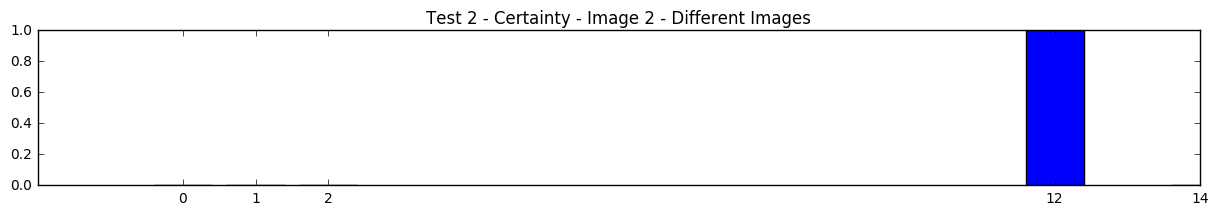

In [92]:
axes = plt.gca()
axes.set_xlim([-2,7])
plt.rcParams["figure.figsize"] = [15, 2]
plt.bar(vals2[1][1], vals2[1][0], tick_label=vals2[1][1], width=0.8, align='center')
plt.title('Test 2 - Certainty - Image 2 - Different Images')
print('Correct - Does not exist on dataset')
print('Predicted - Label 12: Priority road')

Correct - Label 27: Pedestrians
Predicted - Label 1: Speed limit (30km/h)


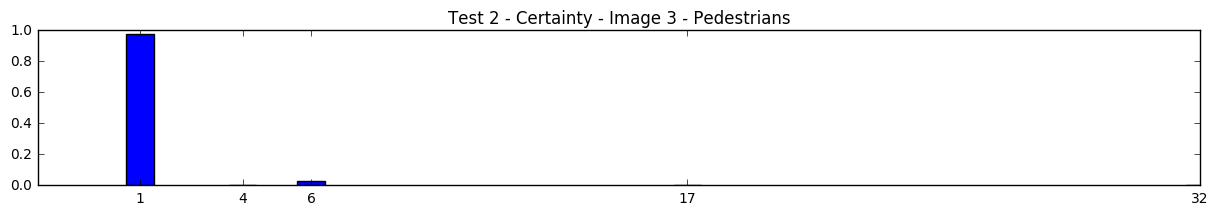

In [98]:
axes = plt.gca()
axes.set_xlim([-2,7])
plt.rcParams["figure.figsize"] = [15, 2]
plt.bar(vals2[2][1], vals2[2][0], tick_label=vals2[2][1], width=0.8, align='center')
plt.title('Test 2 - Certainty - Image 3 - Pedestrians')
print('Correct - Label 27: Pedestrians')
print('Predicted - Label 1: Speed limit (30km/h)')

Correct - Label 14: Stop
Predicted - Label 14: Stop


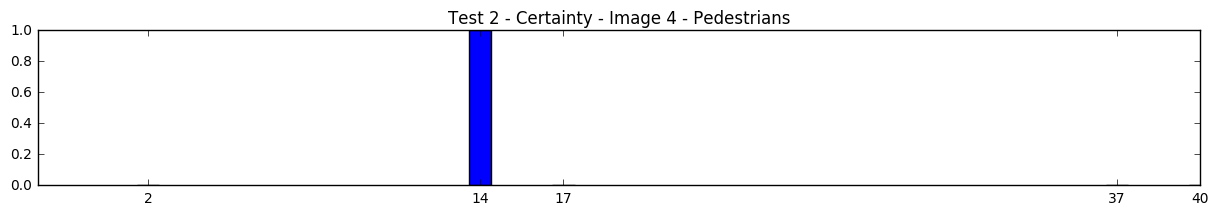

In [99]:
axes = plt.gca()
axes.set_xlim([-2,7])
plt.rcParams["figure.figsize"] = [15, 2]
plt.bar(vals2[3][1], vals2[3][0], tick_label=vals2[3][1], width=0.8, align='center')
plt.title('Test 2 - Certainty - Image 4 - Pedestrians')
print('Correct - Label 14: Stop')
print('Predicted - Label 14: Stop')

Correct - Label 13: Yield
Predicted - Label 13: Yield


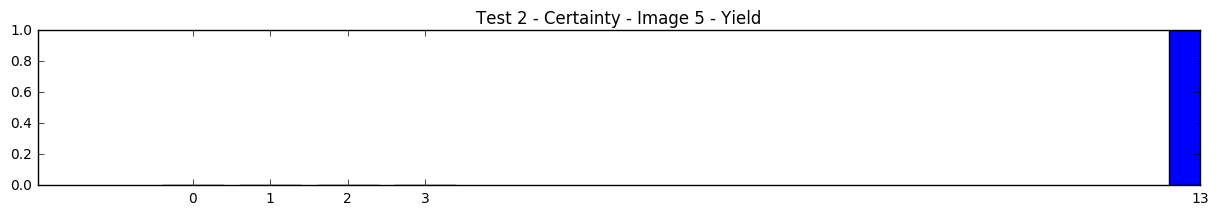

In [101]:
axes = plt.gca()
axes.set_xlim([-2,7])
plt.rcParams["figure.figsize"] = [15, 2]
plt.bar(vals2[4][1], vals2[4][0], tick_label=vals2[4][1], width=0.8, align='center')
plt.title('Test 2 - Certainty - Image 5 - Yield')
print('Correct - Label 13: Yield')
print('Predicted - Label 13: Yield')

Softmax probabilities for Test 3 - German Traffic Signs (Google Street)

[TopKV2(values=array([ 1.,  0.,  0.,  0.,  0.], dtype=float32), indices=array([25,  0,  1,  2,  3], dtype=int32)), TopKV2(values=array([ 1.,  0.,  0.,  0.,  0.], dtype=float32), indices=array([34,  0,  1,  2,  3], dtype=int32)), TopKV2(values=array([  9.99973893e-01,   2.60832385e-05,   3.94603568e-08,
         1.21205170e-08,   4.00146805e-09], dtype=float32), indices=array([36, 19, 25,  1,  7], dtype=int32)), TopKV2(values=array([  1.00000000e+00,   2.73193801e-10,   2.19252361e-15,
         1.66464266e-20,   2.39090033e-22], dtype=float32), indices=array([12, 40,  9,  3, 41], dtype=int32)), TopKV2(values=array([  1.00000000e+00,   5.92802890e-11,   1.32889534e-14,
         3.60860622e-22,   1.00725429e-24], dtype=float32), indices=array([35, 34,  3, 38,  6], dtype=int32))]


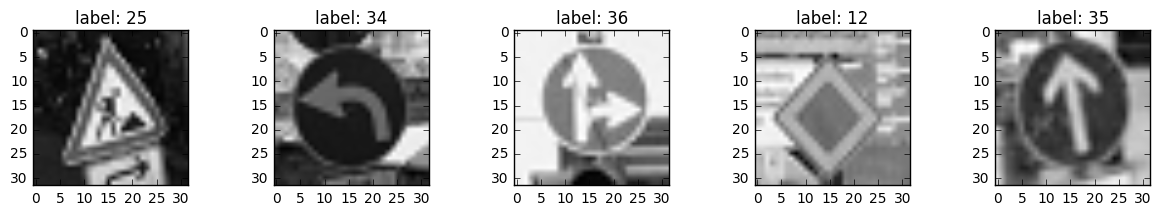

In [85]:
print("Softmax probabilities for Test 3 - German Traffic Signs (Google Street)")
print()
vals3 = []
for i in range(0,5):
    image3 = images3[i].squeeze() 
    plt.subplot(1,5,i+1)
    plt.imshow(image3, cmap="gray")
    plt.title('label: %d' % y_final_test3[i])
with tf.Session() as sess:
    for i in range(0,5):
        val3 = sess.run(tf.nn.top_k(tf.constant(final_test3_values[i]), k=5)) 
        vals3.append(val3)  
print(vals3)

Correct - Label 25: Road work
Predicted - Label 25: Road work


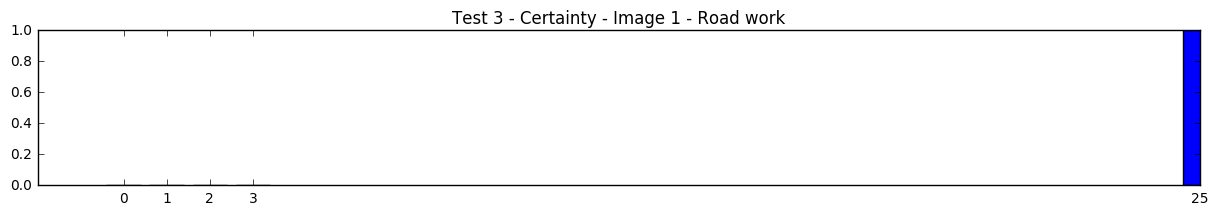

In [103]:
axes = plt.gca()
axes.set_xlim([-2,7])
plt.rcParams["figure.figsize"] = [15, 2]
plt.bar(vals3[0][1], vals3[0][0], tick_label=vals3[0][1], width=0.8, align='center')
plt.title('Test 3 - Certainty - Image 1 - Road work')
print('Correct - Label 25: Road work')
print('Predicted - Label 25: Road work')

Correct - Label 34: Turn Left
Predicted - Label 34: Turn Left


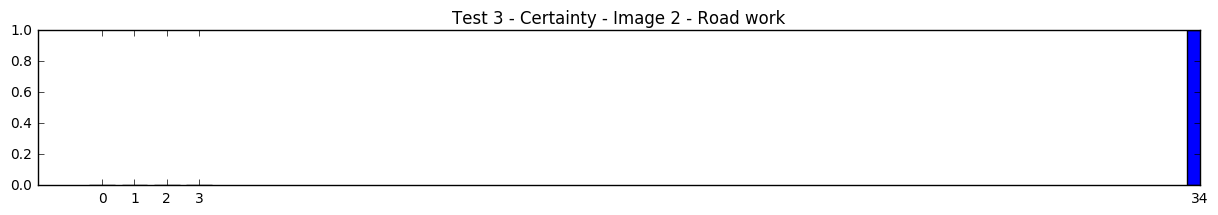

In [105]:
axes = plt.gca()
axes.set_xlim([-2,7])
plt.rcParams["figure.figsize"] = [15, 2]
plt.bar(vals3[1][1], vals3[1][0], tick_label=vals3[1][1], width=0.8, align='center')
plt.title('Test 3 - Certainty - Image 2 - Road work')
print('Correct - Label 34: Turn Left')
print('Predicted - Label 34: Turn Left')

Correct - Label 36: Go straight or right
Predicted - Label 36: Go straight or right


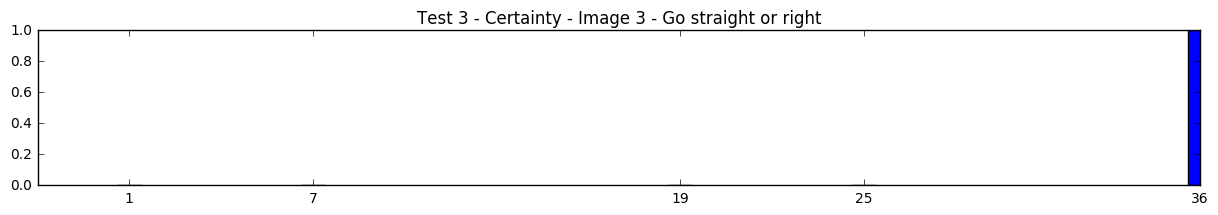

In [107]:
axes = plt.gca()
axes.set_xlim([-2,7])
plt.rcParams["figure.figsize"] = [15, 2]
plt.bar(vals3[2][1], vals3[2][0], tick_label=vals3[2][1], width=0.8, align='center')
plt.title('Test 3 - Certainty - Image 3 - Go straight or right')
print('Correct - Label 36: Go straight or right')
print('Predicted - Label 36: Go straight or right')

Correct - Label 12: Priority road
Predicted - Label 12: Priority road


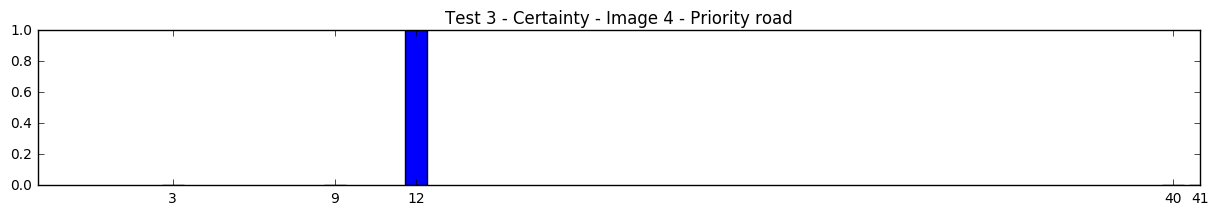

In [109]:
axes = plt.gca()
axes.set_xlim([-2,7])
plt.rcParams["figure.figsize"] = [15, 2]
plt.bar(vals3[3][1], vals3[3][0], tick_label=vals3[3][1], width=0.8, align='center')
plt.title('Test 3 - Certainty - Image 4 - Priority road')
print('Correct - Label 12: Priority road')
print('Predicted - Label 12: Priority road')

Correct - Label 35: Ahead only
Predicted - Label 35: Ahead only


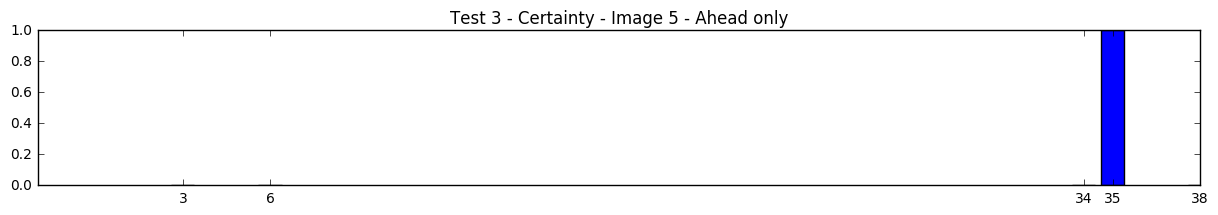

In [110]:
axes = plt.gca()
axes.set_xlim([-2,7])
plt.rcParams["figure.figsize"] = [15, 2]
plt.bar(vals3[4][1], vals3[4][0], tick_label=vals3[4][1], width=0.8, align='center')
plt.title('Test 3 - Certainty - Image 5 - Ahead only')
print('Correct - Label 35: Ahead only')
print('Predicted - Label 35: Ahead only')

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**
Honestly, I would not trust a model that fails 9 out of 100 trials. However, the model achieve high certainty to classify traffic signs, the model does not hesitate to classify different types of traffic signals, even when the prediction fails. Also, i think that with fine tunning the model could achieve better accuracy.

For **Final Test 1** the accuracy achieves **90%**, the model fails to predict the following sign: 
* Stop, the model predicts label 17 (almost 1 of certainly) instead label 14. So, the correct prediction is the third one of the largest 5 probabilities with a 2.27045572e-15 of certainly. This would because both signs ("No entry" and "Stop") are pretty similar, maybe the model have issues predicting signs that contains letters. 

For **Final Test 2** the accuracy achieves **40%**, the model fails to predict the following 3 signs:
* Turn Left Able, the model predicts label 40 (9.99971509e-01 of certainly) instead label 34. So, the correct prediction does not appear on the largest 5 probabilities, also shape and color are different. The sign has different shape and color.
* Rifht Merge, the model predicts label 12 (almost 1 of certainly) instead label 35. So, the correct prediction does not appear on the largest 5 probabilities, also this traffic sign particularly does not exist on the train dataset.The sign does not exist on the dataset. 
* Pedestrians, the model predicts label 1 (9.74286973e-01 of certainly)  instead label 27. So, the correct prediction does not appear on the largest 5 probabilities, also shape and color are different. The sign has different shape and color.

For **Final Test 3** the model achieve perfect accuracy **100%**. The model predicts certainly the five signs with almost 1.0 of probability.


> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

**Note:**
For some reason the answers to the questions 7 and 8 were lose. However, you also watch the answers on the file named Report_Virtual_Machine.html.

Regards,

**Julio Fajardo**